# Medical Cost Dataset

This dataset contains personal information of different patients, which can be used to predict medical cost via linear regression. Exploratory data analysis (EDA), data cleaning and data modeling will be demonstrated.


The dataset contains the following columns:

- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body weights, that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_ind_from_stats, f_oneway
from math import log

In [2]:
# Load data
insurance = pd.read_csv("insurance.csv")
insurance.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## General information about the dataset

For a small dataset like this, it is obvious that we have 3 categorical features('sex', 'smoker', and 'region') and 3 numerical features ('age', 'bmi', and 'chidren') and 1 numerical target ('charges'). However, for more complicated dataset, it is very helpful to look at the column information and check if there are Null values before moving on to exploratory data analysis.

In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Exploratory data analysis

Since the goal is to create a model that uses the given features to predict the medical cost ("charges"), we need to investigate the correlation between these features and the medical cost.

### Categorical features

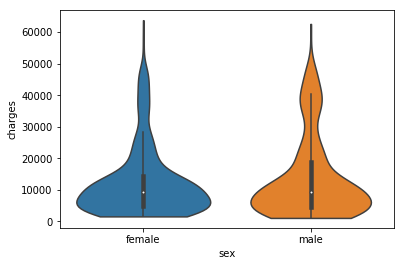

In [4]:
# Sex
sns.violinplot(x='sex', y='charges',data=insurance,cut=0)

In [5]:
# Perform t-test to check if there is statistically meaningful difference between female groud and male group
mean_f, mean_m = insurance[insurance['sex']=='female']['charges'].mean(), insurance[insurance['sex']=='male']['charges'].mean()
std_f, std_m = insurance[insurance['sex']=='female']['charges'].std(), insurance[insurance['sex']=='male']['charges'].std()
n_f, n_m = len(insurance[insurance['sex']=='female']['charges']), len(insurance[insurance['sex']=='male']['charges'])

print('P value for t-test is {}'.format(ttest_ind_from_stats(mean_f, std_f, n_f, mean_m, std_m, n_m).pvalue))


P value for t-test is 0.03613272100592976


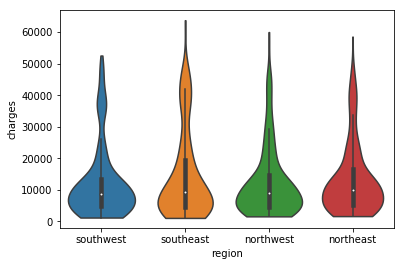

In [6]:
# Region
sns.violinplot(x='region', y='charges',data=insurance,cut=0)

In [7]:
#Perform one-way ANOVA to check if there is statistically meaningful difference between different regions
sw = insurance[insurance['region']=='southwest']['charges']
se = insurance[insurance['region']=='southeast']['charges']
nw = insurance[insurance['region']=='northwest']['charges']
ne = insurance[insurance['region']=='northeast']['charges']

print('P value for one-way ANOVA is {}'.format(f_oneway(sw,se,nw,ne).pvalue))

P value for one-way ANOVA is 0.0308933560705201


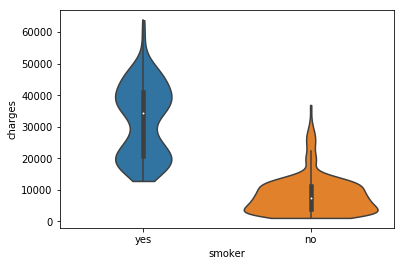

In [8]:
#Smoker
sns.violinplot(x='smoker', y='charges',data=insurance,cut=0)

In [9]:
# Perform t-test to check if there is statistically meaningful difference between smoker groud and non-smoker group
mean_s, mean_n = insurance[insurance['smoker']=='yes']['charges'].mean(), insurance[insurance['smoker']=='no']['charges'].mean()
std_s, std_n = insurance[insurance['smoker']=='yes']['charges'].std(), insurance[insurance['smoker']=='no']['charges'].std()
n_s, n_n = len(insurance[insurance['smoker']=='yes']['charges']), len(insurance[insurance['smoker']=='no']['charges'])

print('P value for t-test is {}'.format(ttest_ind_from_stats(mean_s, std_s, n_s, mean_n, std_n, n_n).pvalue))

P value for t-test is 8.271435842174398e-283


For three categorical features, it seems significant difference in medical costs is  observed for "smoker" as the p-value is extremely small. For "region" and "sex", the distribution of "charges" was quite similar between categories, although the p-values were less than 0.05, and therefore were not considered further.

### Numerical features

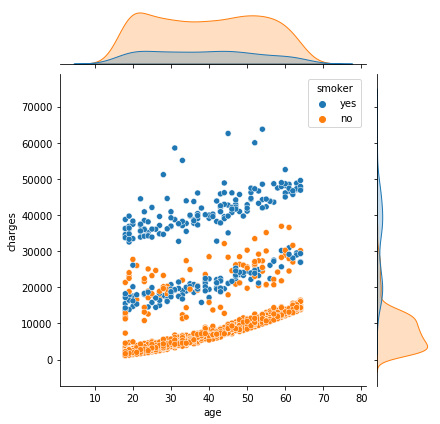

In [10]:
# Age
sns.jointplot(x='age',y='charges',data=insurance,hue='smoker')

The graph shows that, in general, there is a weak positive correlation between the medical costs and the age of the patient. The distribution shows that the age is almost evenly distributed, except at the low end; and most medical costs are tightly clustered below 15,000. There appear to be three parallel subgroups to each other in the scatter plot, suggesting that age does not fully determine the medical costs.


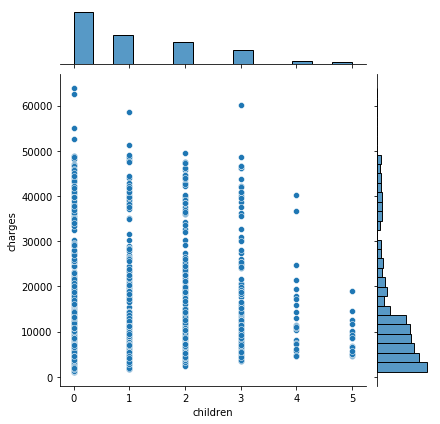

In [11]:
# Children
sns.jointplot(x='children', y='charges', data=insurance)

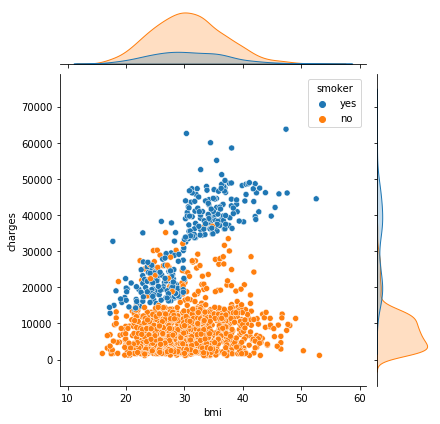

In [12]:
#BMI
sns.jointplot(x='bmi', y='charges',data=insurance, hue='smoker')

Suprisingly, "bmi" follows a normal distribution, and for smokers is this a strong positive correlation between "bmi" and "charges.





## Encoding, Scaling Features

For categorical features, we need to convert the strings to numbers through encoding. Feature scaling will help the model converge faster during optimization. For feature scaling, only training data should be used to calculate the sample statistics, otherwise, 'data leakage' may occur. To better split the train-test sets, we use stratified sampling to insure both sets have similar percentage smokers.

In [13]:
# Onehotencoding
encoder = OneHotEncoder(drop='first')
encoded = encoder.fit_transform(insurance[['sex','smoker','region']])
encoded_df = pd.DataFrame(encoded.toarray(), index=insurance.index,columns=['sex_encode','smoker_encode','southeast','northwest','northeast'])
insurance.drop(columns=['sex','smoker','region'],inplace=True)
insurance = pd.concat([insurance, encoded_df], axis=1)

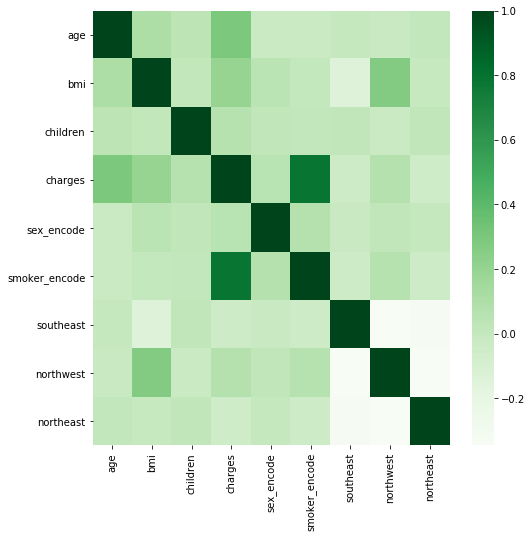

In [14]:
plt.figure(figsize=(8,8))
sns.heatmap(insurance.corr(),cmap='Greens')

In [15]:
X = insurance.drop(columns=['charges'])
y = insurance['charges']

# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify = insurance['smoker_encode'])

# Feature scaling
scaler = StandardScaler()
scaler.fit(X_train[['age','bmi','children']])
X_train[['age','bmi','children']] = scaler.transform(X_train[['age','bmi','children']])
X_test[['age','bmi','children']] = scaler.transform(X_test[['age','bmi','children']])


## Modeling Data

First, I would use a random forest model, then I will show how neural network improves the prediction results.

Regression Score: 0.8339607249095825


Text(0, 0.5, 'Real charges')

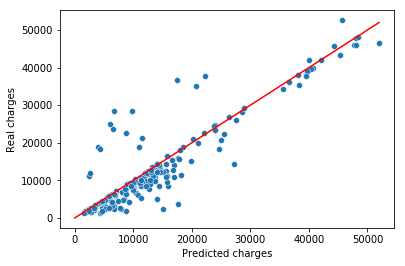

In [16]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print('Regression Score: {}'.format(rf.score(X_test,y_test)))
sns.scatterplot(rf.predict(X_test),y_test)
sns.lineplot(np.linspace(0,52000,1000),np.linspace(0,52000,1000),color='r')
plt.xlabel('Predicted charges')
plt.ylabel('Real charges')

Text(0, 0.5, 'Real charges')

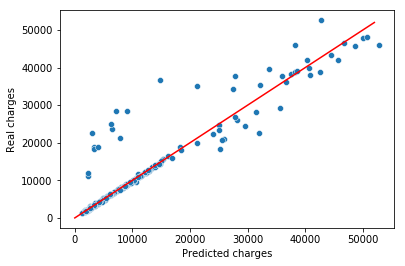

In [17]:
# Using Neural Network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]

NN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split = 0.2, verbose=0) #, callbacks=callbacks_list)
predict = NN_model.predict(X_test)

sns.scatterplot(predict[:,0], y_test)
sns.lineplot(np.linspace(0,52000,1000),np.linspace(0,52000,1000),color='r')
plt.xlabel('Predicted charges')
plt.ylabel('Real charges')